In [457]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# IMPLEMENT A BASIC IMAGE PROCESSING PIPELINE

## INITIALS (5 PTS)

In [458]:
img = Image.open('data/banana_slug.tiff')
imarray = np.array(img)
height, width = imarray.shape
print("height is %d, and width is %d" % (height, width))
print(imarray.dtype)

img_double = imarray.astype('double')
print(img_double.dtype)

height is 2856, and width is 4290
uint16
float64


## LINEARIZATION (5 POINTS)

In [459]:
print("max/min before linearization : %.5f %.5f" %(img_double.max(), img_double.min()))
linear_img = (img_double - 2047) / (15000 - 2047)
print("max/min after shift/scale : %.5f %.5f" %(linear_img.max(), linear_img.min()))
linear_img = np.clip(linear_img, 0, 1)
print("max/min after clipping : %.5f %.5f" %(linear_img.max(), linear_img.min()))

max/min before linearization : 15303.00000 2002.00000
max/min after shift/scale : 1.02339 -0.00347
max/min after clipping : 1.00000 0.00000


## WHITE BALANCING (20 POINTS)

In [460]:
def bayer_to_rgb(pattern, image):
    img_shape = image.shape
    channels = {}
    for ch in "rgb":
        channels[ch] = np.zeros(image.shape, dtype='bool')
    pos = [(0,0), (0,1), (1,0), (1,1)]
    for ch, (y,x) in zip(pattern, pos):
        channels[ch][y::2, x::2] = 1
    
    
    red_im = image * channels['r']
    green_im = image * channels['g']
    blue_im = image * channels['b']
    bayer_img = np.dstack([red_im, green_im, blue_im])
    
    return bayer_img

# gray world assumption
def gray_world(img):
    ch_mean = np.mean(img, axis=(0,1))
    norm_img_gray = img / ch_mean * ch_mean[1] # ch_mean[1] : grenn channel avg
    return norm_img_gray

# white world assumption
def white_world(img):
    ch_max = np.max(img, axis=(0,1))
    norm_img_white = img / ch_max * ch_max[1] # ch_max[1] : grenn channel max
    return norm_img_white
    
    
rgb_img = bayer_to_rgb('rggb', linear_img)
norm_img_gray = gray_world(rgb_img)
norm_img_white = white_world(rgb_img)


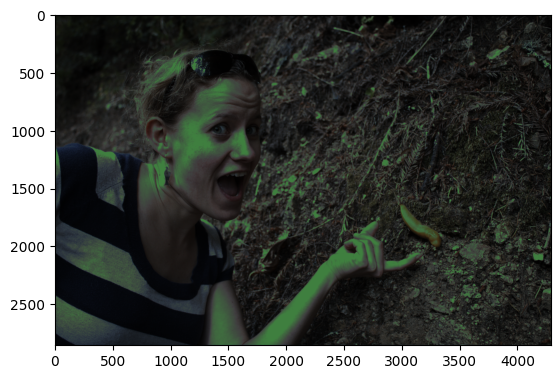

In [461]:
plt.imshow(np.minimum(1, norm_img_gray*5))

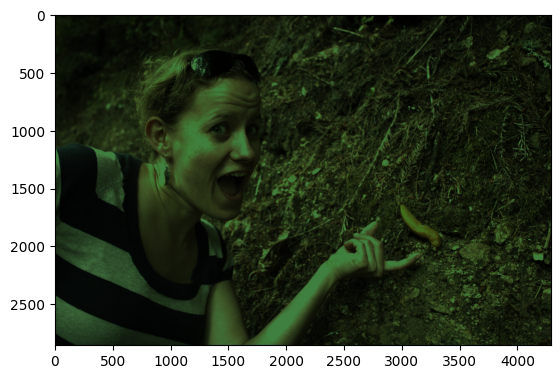

In [462]:
plt.imshow(np.minimum(1, norm_img_white*5))

## DEMOSAICING (25 POINTS)

([], [])

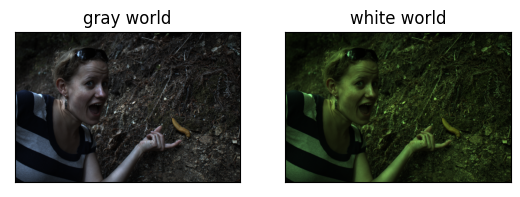

In [463]:
int_img_gray = cv2.resize(norm_img_gray, (norm_img_gray.shape[1]//2, norm_img_gray.shape[0]//2),interpolation=cv2.INTER_LINEAR)
int_img_white = cv2.resize(norm_img_white, (norm_img_white.shape[1]//2, norm_img_white.shape[0]//2),interpolation=cv2.INTER_LINEAR)

fig = plt.figure()
plt.subplot(121)
plt.imshow(np.minimum(1,int_img_gray*5))
plt.title('gray world')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(np.minimum(1,int_img_white*5))
plt.title('white world')
plt.xticks([])
plt.yticks([])

## IDENTIFYING THE CORRECT BAYER PATTERN (20 POINTS)

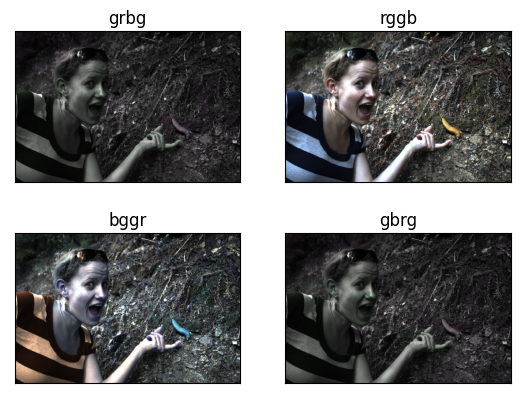

In [464]:
fig = plt.figure()

pattern_list = ['grbg', 'rggb', 'bggr', 'gbrg']

for i, pattern in enumerate(pattern_list,1):
    im_rgb = bayer_to_rgb(pattern, linear_img) # convert bayer pattern to rgb channels
    im_rgb = gray_world(im_rgb) # white balancing by gray-world assumption
    # demosaicing by bilinear interpolation
    im_rgb = cv2.resize(im_rgb, (im_rgb.shape[1]//2, im_rgb.shape[0]//2),interpolation=cv2.INTER_LINEAR) 
    plt.subplot(2,2,i)
    plt.imshow(np.minimum(1,im_rgb*10))
    plt.title(pattern)
    plt.xticks([])
    plt.yticks([])

plt.show()

## BRIGHTNESS ADJUSTMENT AND GAMMA CORRECTION (20 POINTS)

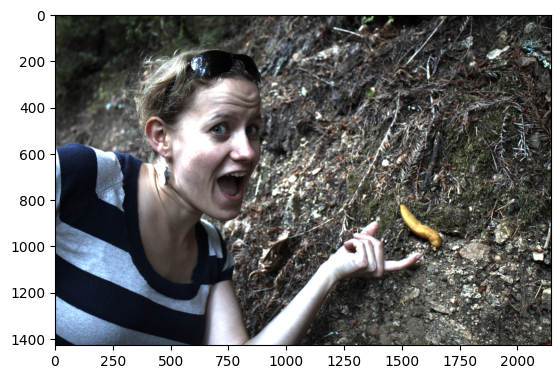

In [465]:
from skimage import color
from skimage import io
import matplotlib.cm as cm

gray_img = color.rgb2gray(int_img_gray)
max_value = gray_img.max()

brighten_img = int_img_gray / (max_value * 0.2)
plt.imshow(np.minimum(1, brighten_img), cmap=cm.gray)
gamma_img = brighten_img.copy()
for ch in range(3): # RGB
    ch_img = brighten_img[:, :, ch]
    w,h,_ = brighten_img.shape
    ch_img = ch_img.flatten()
    for x in range(len(ch_img)):
        if ch_img[x] <= 0.0031308:
            ch_img[x] *= 12.92
        else:
            ch_img[x] = (1+0.055) * ch_img[x] ** (1/2.4) - 0.055
    ch_img = ch_img.reshape((w,h))
    gamma_img[:,:,ch] = ch_img
gamma_img = np.minimum(1, gamma_img)

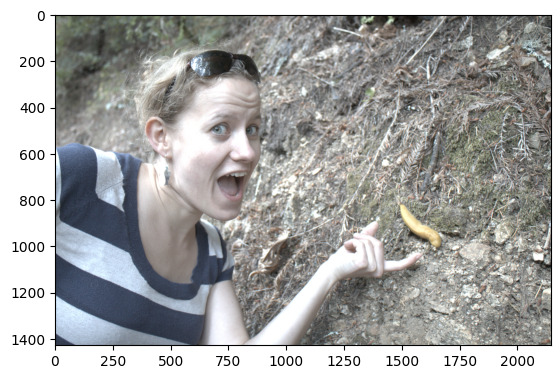

In [466]:
plt.imshow(gamma_img)

## COMPRESSION (5 PTS) 

In [467]:
cv2.imwrite("final_img.png", (255*gamma_img[:,:,::-1]).astype(np.uint8), [cv2.IMWRITE_PNG_COMPRESSION, 0])
cv2.imwrite("final_img.jpeg", (255*gamma_img[:,:,::-1]).astype(np.uint8), [cv2.IMWRITE_JPEG_QUALITY, 95])

True

In [468]:
import os
png_size = os.path.getsize('final_img.png')
jpeg_size = os.path.getsize('final_img.jpeg')
ratio = png_size / jpeg_size
print(ratio)

6.76175732801522


In [469]:
cv2.imwrite("final_img_test.jpeg", (255*gamma_img[:,:,::-1]).astype(np.uint8), [cv2.IMWRITE_JPEG_QUALITY, 25])
jpeg_size = os.path.getsize('final_img_test.jpeg')
ratio = png_size / jpeg_size
print(ratio)

43.15441700420042
